In [219]:
#Requisite Libraries
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download("punkt") #this only needs to be run once per system
#nltk.download("vader_lexicon")
import spacy #also run: "python -m spacy download en_core_web_sm" in terminal
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
from datetime import datetime
import re

Question 1: It is an important skill to look at the data and come up with questions that you can
answer. What are some compelling questions that you can ask with the provided dataset (list at
least 2 questions)? (5 points)

1. What is the distribution of sentiments within the tweets?
2. Is there a correlation between sentiment and tweet engagement (retweet or favorite)?
3. What are the most frequent topics mentioned in the tweets?
4. Who were the most frequently mentioned people or hashtags within the tweets?

Question 2: Inspect & Data Cleaning  
● Inspect: Write code to inspect the data. What do you observe? Along with the code,
write your observation in the markdown cell. (2.5 points)  
● Clean: Write code to clean the data. Use at least 5 methods. For each method, along
with the code, you need to write the rationale behind the cleaning process. For this
question, you can assume that you are solving one of the questions that you wrote for
the first question. (5 points)  
● Tokenize: Write code to tokenize your entire dataset. Use at least 2 different types of
tokenizers. Compare their results and write your observations. (2.5 points)

In [220]:
#Read in data and inspect
tweet_df = pd.read_csv("trump_20200530.csv")
print(tweet_df.head())
print(tweet_df.info())
print(tweet_df.shape)
print(tweet_df.columns)
print("\nmissing values count:\n{}".format(tweet_df.isna().sum()))
print("Duplicate count: {}".format(tweet_df.duplicated().sum()))
print("Source contains homogenous values: {}".format((tweet_df["source"] == tweet_df["source"].iloc[0]).all()))
print("The unique values for source are: {}".format(tweet_df["source"].unique()))

               source                                               text  \
0  Twitter for iPhone  RT @ScottAdamsSays: Malaria drug and zinc the ...   
1  Twitter for iPhone  RT @YoungDems4Trump: In Democrat cities you ca...   
2  Twitter for iPhone  RT @YoungDems4Trump: So sad. This poor busines...   
3  Twitter for iPhone   Time for a change! #2020 https://t.co/AECy2GBfys   
4  Twitter for iPhone  RT @TallahForTrump: Trump spoke at my church i...   

            created_at  retweet_count  favorite_count is_retweet  \
0  05-30-2020 03:26:31          10566               0       True   
1  05-30-2020 03:21:41          22320               0       True   
2  05-30-2020 03:21:32          23961               0       True   
3  05-30-2020 03:20:18          42879          164022      False   
4  05-30-2020 03:19:01          36563               0       True   

                id_str  
0  1266571665204527109  
1  1266570449431003138  
2  1266570411678019584  
3  1266570099454103553  
4  126656

In [221]:
#Clean data
#Assuming we're trying to find the distribution of sentiments within the tweets

#There are 58 rows with missing values out of 18446 total rows. We can drop these rows with negligable impact.
tweet_df.dropna(inplace=True)
print(tweet_df.isna().sum())

#homogenize text by converting text to lower case, this should increase model accuracy
tweet_df["text"].str.lower()

#remove stopwords, this reduces noise and dimensionality yielding better performance
def cleanStopWords(text):
    words = text.split() 
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text
    
tweet_df["text"] = tweet_df["text"].apply(cleanStopWords)

#extract date from time-time field to make it usable for plotting
print(tweet_df.keys())
tweet_df["date"] = pd.to_datetime(tweet_df['created_at'])
tweet_df.drop(columns=["created_at"], inplace=True)

#remove special characters
def remove_special_characters(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

tweet_df['text'] = tweet_df['text'].apply(remove_special_characters)

source            0
text              0
created_at        0
retweet_count     0
favorite_count    0
is_retweet        0
id_str            0
dtype: int64
Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'id_str'],
      dtype='object')


In [230]:
#Tokenize text
tokenizer = spacy.load("en_core_web_sm")
def spacy_tokenize(text):
    document = tokenizer(text)
    tokens = [token.text for token in document]
    return tokens
    
tweet_df["spacy_tokens"] = tweet_df["text"].apply(spacy_tokenize)

def nltk_tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens
    
tweet_df["nltk_tokens"] = tweet_df["text"].apply(nltk_tokenize)

In [225]:
#Compare Results
num_spacy_tokens = tweet_df['spacy_tokens'].apply(len).sum()
num_nltk_tokens = tweet_df['nltk_tokens'].apply(len).sum()
print("Total spacy tokens: {}".format(num_spacy_tokens))
print("Total NLTK tokens: {}".format(num_nltk_tokens))

tweet_df['spacy_tokens_set'] = tweet_df['spacy_tokens'].apply(set)
tweet_df['nltk_tokens_set'] = tweet_df['nltk_tokens'].apply(set)
tweet_df['differences'] = tweet_df.apply(lambda row: row['spacy_tokens_set'].symmetric_difference(row['nltk_tokens_set']), axis=1)
for index, row in tweet_df.iterrows():
    if len(row['differences']) > 0:
        print(f"Row {index} - Differences: {row['differences']}")

#This method doesn't give any insightful information, by joining the tokens we lose how they were split differently, leaving it for documentation purposes
# token_df = pd.DataFrame()
# token_df['spacy_tokens_str'] = tweet_df['spacy_tokens'].apply(lambda x: ' '.join(x))
# token_df['nltk_tokens_str'] = tweet_df['nltk_tokens'].apply(lambda x: ' '.join(x))
# filtered_tokens = token_df.drop_duplicates(subset=['spacy_tokens_str', 'nltk_tokens_str'])
# for i in range(len(filtered_tokens['spacy_tokens_str'])):
#     print("{} || {}\n".format(filtered_tokens['spacy_tokens_str'].iloc[i], filtered_tokens['nltk_tokens_str'].iloc[i]))

KeyError: 'spacy_tokens'

It looks like the two tokenizers are very similar. However there are slight differences on many rows, for example one tokenizer considered 11pm to be '11' and 'pm' while the other considered it to be '11pm'. These differences will most likely not affect training performance because the meaning of the tokens is retained. Its also worth noting that tokenization is a very computationally expensive task. This the tokenization step took 192 minutes to execute on my computer with a core i7 cpu.

Question 3: Learn how to use new Python packages or online APIs (10 points)
Pick an existing package a library or an API to determine the sentiment (positive, negative,
neutral) for each of the tweets in the dataset. You can also use open-source code provided on
GitHub repos. DO NOT WRITE THE SENTIMENT ANALYSIS CODE FROM SCRATCH
For example: Use VADER sentiment analysis from NLTK

In [226]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(tokens):
    text = " ".join(tokens)
    sentiment = sentiment_analyzer.polarity_scores(text)
    return sentiment["compound"]

tweet_df["sentiment_score"] = tweet_df["nltk_tokens"].apply(analyze_sentiment)

def classify_sentiment_score(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

tweet_df["sentiment_label"] = tweet_df["sentiment_score"].apply(classify_sentiment_score)

Question 4: Analyze Data over time (10 points)
How does the sentiment of your corpus change over time? Answer this question by showing
plots (at least 2 graphs). Be creative!

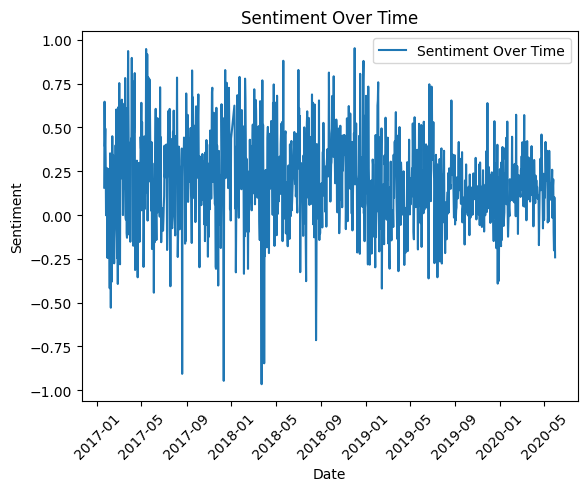

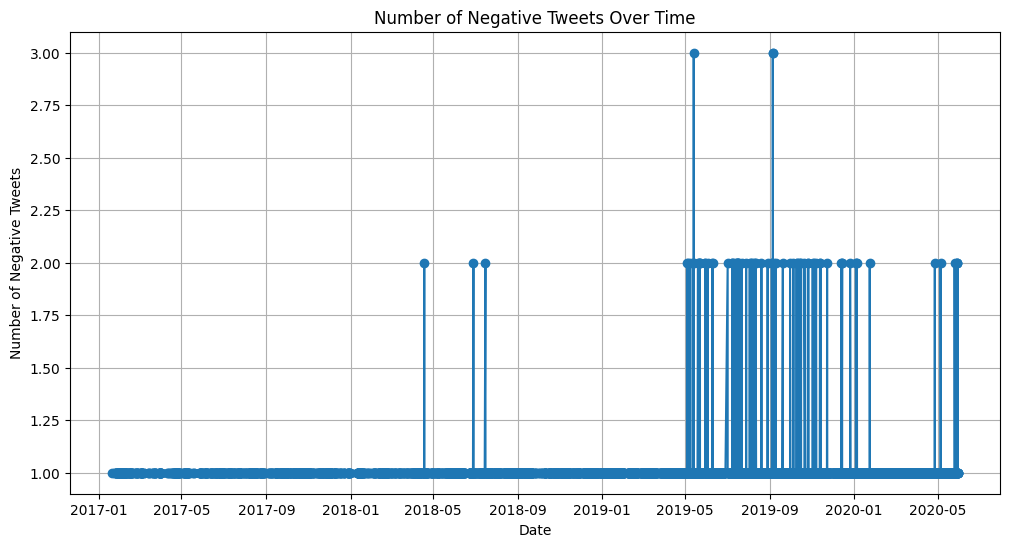

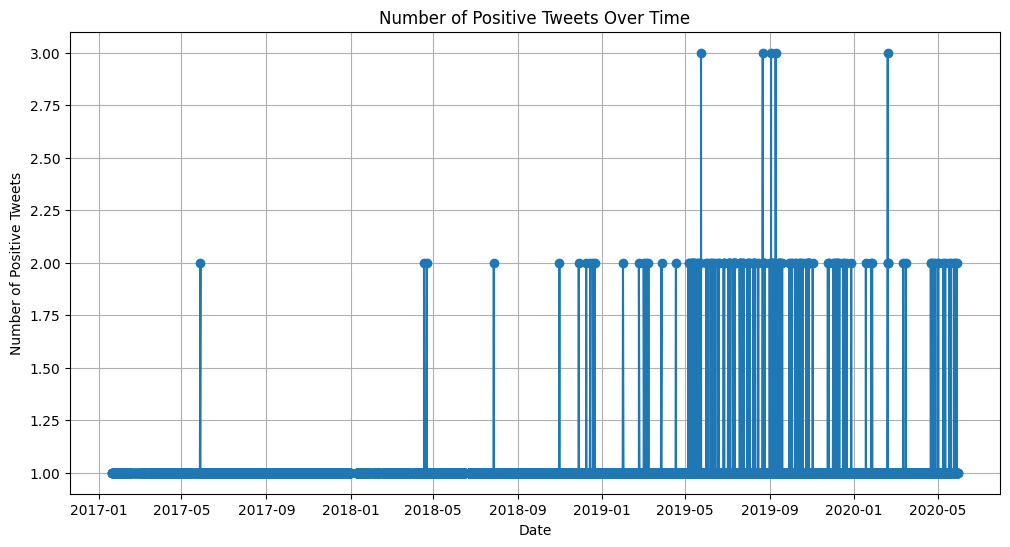

In [231]:
daily_sentiment = tweet_df.groupby(tweet_df['date'].dt.date)['sentiment_score'].mean()

plt.plot(daily_sentiment.index, daily_sentiment.values, label='Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()

negative_tweets = tweet_df[tweet_df["sentiment_label"] == "negative"]
negative_tweets_count = negative_tweets.groupby('date').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
plt.plot(negative_tweets_count['date'], negative_tweets_count['count'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Negative Tweets')
plt.title('Number of Negative Tweets Over Time')
plt.grid(True)
plt.show()


positive_tweets = tweet_df[tweet_df["sentiment_label"] == "positive"]
positive_tweets_count = positive_tweets.groupby('date').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
plt.plot(positive_tweets_count['date'], positive_tweets_count['count'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Positive Tweets')
plt.title('Number of Positive Tweets Over Time')
plt.grid(True)
plt.show()

From a numerical perspective it looks like the a slight majority of trump's tweets are skewed slightly positively - this holds constant across time, see first graph. However, it looks like the magnitude of both positive and negative tweets per day increases during 2019 and slowly tapers off in 2020. This is most likely correlated with the presidential elections at the time and so trump
was actively trying to rally voters' emotions.